<img align="right" width="400" src="https://drive.google.com/thumbnail?id=1rPeHEqFWHJcauZlU82a4hXM10TUjmHxM&sz=s4000" alt="FHNW Logo">


# Structured Information Extraction with a LLM

by Fabian Märki

## Summary
The aim of this notebook is to showcase (structured) Information Extraction by instructing a LLM to extract information in a structured format. 

LLMs produce free text by default. Assuming that the LLM should become part of a software stack (e.g. as a microservice), this faces us with the problem on how to process this text (as other services in the pipeline expect structured input and cannot handle free text). Luckily, there are ways to instruct an LLM to respond in a predefined JSON format (or in a Pydantic class using LangChain's oecosystem).

This notebook contains assigments: <font color='red'>Questions are written in red.</font>

<a href="https://colab.research.google.com/github/markif/NLP_LAB_CAS/blob/master/Structured_Information_Extraction_with_a_LLM.ipynb">
  <img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

In [1]:
%%capture

!pip install 'fhnw-nlp-utils>=0.11.0,<0.12.0'

In [2]:
from fhnw.nlp.utils.storage import download
from fhnw.nlp.utils.image_helpers import image_to_base64

In [3]:
file_llama = "data/llama_waving.png"
file_stop_sign = "data/stop_sign.png"
file_invoice_01 = "data/invoice_01.png"
file_invoice_02 = "data/invoice_02.png"

download("https://drive.switch.ch/index.php/s/X2NMqniYVkjfFOJ/download", file_llama)
download("https://drive.switch.ch/index.php/s/ZX7DLIwlR5e5st2/download", file_stop_sign)
download("https://drive.switch.ch/index.php/s/OIaod1KdHNUAMaY/download", file_invoice_01)
download("https://drive.switch.ch/index.php/s/yykmTbvhIIUX9cM/download", file_invoice_02)

In [4]:
#OLLAMA_HOST='https://XYZ.trycloudflare.com'
OLLAMA_HOST='http://localhost:11434'
OPENAI_BASE_URL=OLLAMA_HOST+"/v1/"

MODEL_MULTIMODAL = "qwen2.5vl:3b"

# ensure (in your environment) that the model is installed
#
# !ollama pull qwen2.5vl:3b
# docker exec -it ollama sh -c "ollama pull qwen2.5vl:3b"

In [5]:
%%capture

!pip install langchain_openai

In [6]:
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate
from IPython import display

In [7]:
llm = ChatOpenAI(
    model = MODEL_MULTIMODAL,
    api_key = "ollama",
    base_url = OPENAI_BASE_URL,
    temperature = 0,
)

In [9]:
prompt = ChatPromptTemplate(
    [
        {
            "role": "system",
            "content": "You are an experienced photographer! /no_think",
        },
        {
            "role": "user",
            "content": [
                {
                    "type": "text",
                    "text": "Describe this image. {level_of_detail}"
                },
                {
                    "type": "image_url",
                    "image_url": "{image_url}",
                }
            ],
        },
    ]
)

chain = prompt | llm

In [10]:
%%time

response = chain.invoke(
    {
        "level_of_detail": "Be as precise as possible.",
        "image_url": image_to_base64(file_llama),
    }
)

print(response.content)

The image is a simple, black-and-white line drawing. It features a small, round creature with a round body, two small arms, and two small legs. The creature has a round head with two small eyes and a small mouth. The creature is waving its right arm, which is extended outward. The drawing style is minimalistic and cartoonish, with clean lines and no shading or color. The creature appears to be in a playful or cheerful pose.
CPU times: user 23.4 ms, sys: 2.06 ms, total: 25.5 ms
Wall time: 2.55 s


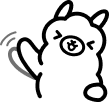

In [11]:
display.Image(file_llama)

In [12]:
%%time

response = chain.invoke(
    {
        "level_of_detail": "Be as precise as possible.",
        "image_url": image_to_base64(file_stop_sign),
    }
)

print(response.content)

The image depicts a hand holding a stop sign. The stop sign is red with a white border and the word "STOP" written in white capital letters. The sign is attached to a brown pole, which is held by the hand. The background is plain white, which makes the red stop sign stand out prominently. The hand appears to be holding the sign steady, suggesting that the person is either about to use the sign or has just received it.
CPU times: user 5.26 ms, sys: 36 μs, total: 5.3 ms
Wall time: 1.62 s


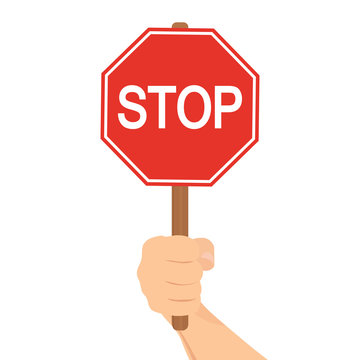

In [13]:
display.Image(file_stop_sign)

Let's assume we need to build a system that processes invoice and that we need to store specific properties of these invoices for later processing (e.g. the invoice number, due date, currency and the total amount of the invoice). 

As we saw above, we can question an LLM to analyse an image and possibly extract specific features from this image. However, when we do it as shown above, we get free text which makes further processing rather difficult. 

Let's see if we can instruct the LLM to produce structured output (e.g. JSON) we can use for further processing (allowing us to interface with other components of our software stack).

The code below showcases how structured JSON output can be requested from an LLM...

In [14]:
llm = ChatOpenAI(
    model = MODEL_MULTIMODAL,
    api_key = "ollama",
    base_url = OPENAI_BASE_URL,
    temperature = 0,
    model_kwargs = { 
        "response_format": { "type": "json_object" }
    },
)

prompt = ChatPromptTemplate(
    [
        {
            "role": "system",
            "content": "You are an experienced photographer! /no_think",
        },
        {
            "role": "user",
            "content": [
                {
                    "type": "text",
                    "text": "This image may or may not contain an animal. Please parse the image and identify the animal and what it is doing, if possible. Please format your response in JSON and use \"containsAnimal\", \"type\" and \"action\" as attributes."
                },
                {
                    "type": "image_url",
                    "image_url": "{image_url}",
                }
            ],
        },
    ]
)

chain = prompt | llm

In [15]:
%%time

response = chain.invoke(
    {
        "image_url": image_to_base64(file_llama),
    }
)

print(response.content)

{
  "containsAnimal": true,
  "type": "cat",
  "action": "waving"
}
CPU times: user 20.9 ms, sys: 1 ms, total: 21.9 ms
Wall time: 577 ms


In [16]:
%%time

response = chain.invoke(
    {
        "image_url": image_to_base64(file_stop_sign),
    }
)

print(response.content)

{
  "containsAnimal": false,
  "type": "human",
  "action": "holding a stop sign"
}
CPU times: user 6.27 ms, sys: 781 μs, total: 7.05 ms
Wall time: 800 ms


<font color='red'>**TASK: Implement a prompt that instructs the LLM to extract the properties `number`, `due_date`,  `currency` and `total_amount` from the provided invoices.**</font>

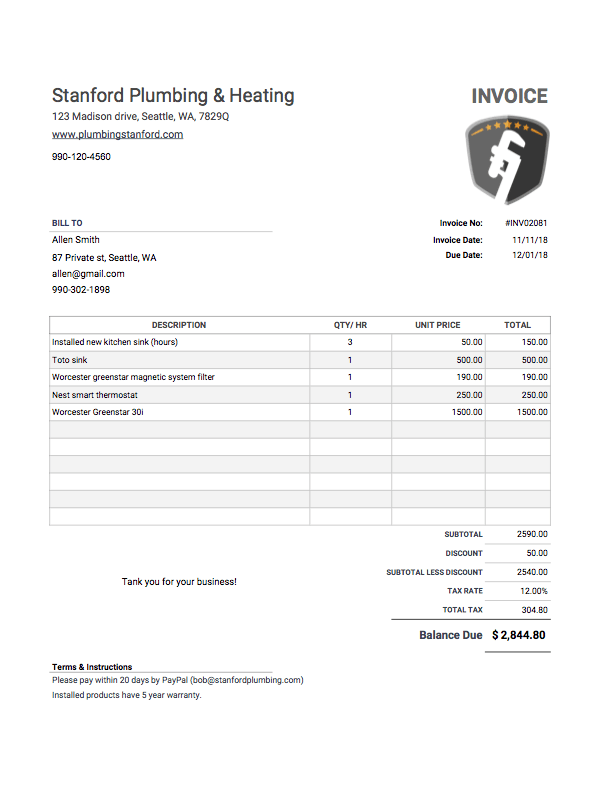

In [17]:
display.Image(file_invoice_01)

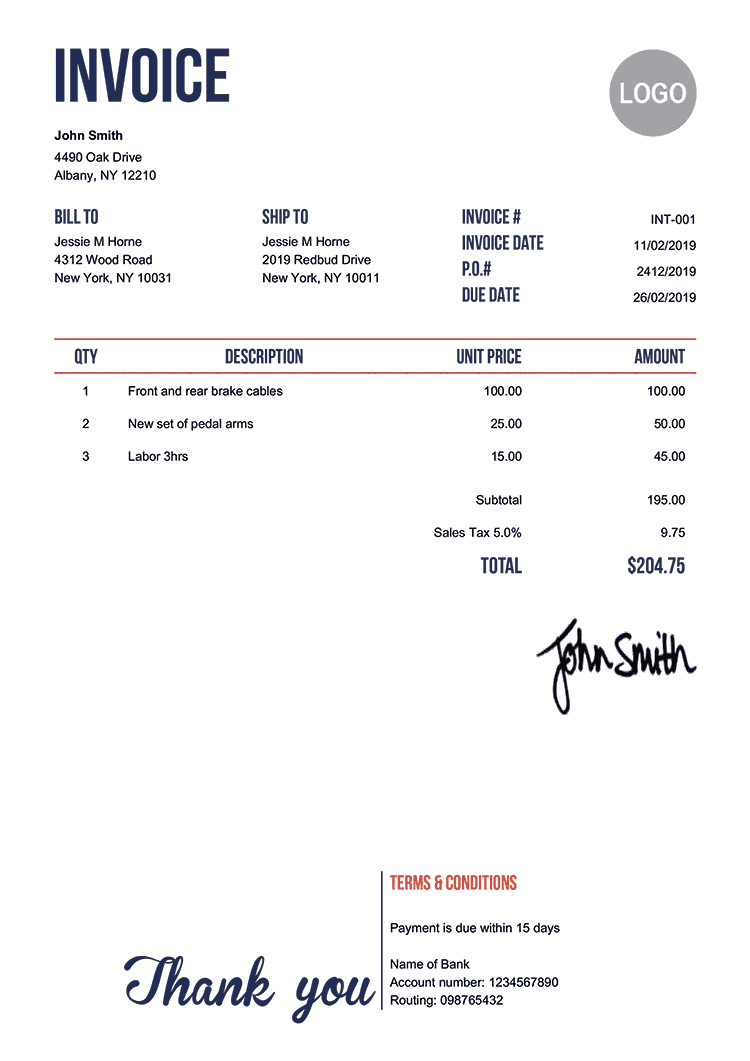

In [18]:
display.Image(file_invoice_02)

In [19]:
# llm = ChatOpenAI(...)

llm = ChatOpenAI(
    model = MODEL_MULTIMODAL,
    api_key = "ollama",
    base_url = OPENAI_BASE_URL,
    temperature = 0,
    model_kwargs = { 
        "response_format": { "type": "json_object" }
    },
)

prompt = ChatPromptTemplate(...)

chain = prompt | llm

In [20]:
%%time

response = chain.invoke(
    {
        "image_url": image_to_base64(file_invoice_01),
    }
)

print(response.content)

{
  "invoice_number": "INV02081",
  "due_date": "12/01/18",
  "currency": "USD",
  "total_amount": "2,844.80"
}
CPU times: user 13.7 ms, sys: 0 ns, total: 13.7 ms
Wall time: 2.43 s


In [21]:
%%time

response = chain.invoke(
    {
        "image_url": image_to_base64(file_invoice_02),
    }
)

print(response.content)

{
  "invoice_number": "INT-001",
  "due_date": "26/02/2019",
  "currency": "USD",
  "total_amount": "$204.75"
}
CPU times: user 5.51 ms, sys: 1.06 ms, total: 6.57 ms
Wall time: 3.95 s


Alternatively, you can specify a JSON schema and use LangChain's feature to extract structured output (see [here](https://python.langchain.com/docs/how_to/structured_output/#typeddict-or-json-schema)).

<font color='red'>**TASK: Specify a JSON schema that defines the invoice and its properties you want to extract and use [LangChain's feature](https://python.langchain.com/docs/how_to/structured_output/#typeddict-or-json-schema) to extract structured output.**</font>

In [22]:
json_schema = {
    ...
}

structured_llm = ...

structured_chain = prompt | structured_llm

In [23]:
%%time

response = structured_chain.invoke(
    {
        "image_url": image_to_base64(file_invoice_01),
    }
)

print(response)

{'invoice_number': 'INV02081', 'total_amount': '2,844.80', 'currency': 'USD'}
CPU times: user 4.82 ms, sys: 1.82 ms, total: 6.64 ms
Wall time: 2.22 s


In [24]:
%%time

response = structured_chain.invoke(
    {
        "image_url": image_to_base64(file_invoice_02),
    }
)

print(response)

{'invoice_number': 'INT-001', 'total_amount': '$204.75', 'currency': 'USD'}
CPU times: user 8.27 ms, sys: 38 μs, total: 8.31 ms
Wall time: 3.72 s


There seem to be issues with the due date...

It is also possible to specify a Pydantic class and instruct the LLM to extract its values (see [here](https://python.langchain.com/docs/how_to/structured_output/#pydantic-class)). The key advantage of using Pydantic is that the generated output will be validated. Pydantic will raise an error if any required fields are missing or if any fields are of the wrong type.

<font color='red'>**TASK: Specify a Pydantic class that defines the invoice and its properties you want to extract and use [LangChain's feature](https://python.langchain.com/docs/how_to/structured_output/#pydantic-class) to extract structured output.**</font>

In [25]:
from typing import Optional

from pydantic import BaseModel, Field
from datetime import date

# Pydantic
# The name of the Pydantic class, the docstring, and the names and provided descriptions of parameters are very important.
# You can effectively think of all of this information as being added to the model prompt.

class Invoice(BaseModel):
...

structured_llm = ...

structured_chain = prompt | structured_llm

In [26]:
%%time

response = structured_chain.invoke(
    {
        "image_url": image_to_base64(file_invoice_01),
    }
)

print(response)

invoice_number='INV02081' due_date='12/01/18' currency='USD' total_amount='2,844.80'
CPU times: user 14.5 ms, sys: 68 μs, total: 14.6 ms
Wall time: 2.37 s


In [27]:
%%time

response = structured_chain.invoke(
    {
        "image_url": image_to_base64(file_invoice_02),
    }
)

print(response)

invoice_number='INT-001' due_date='26/02/2019' currency='USD' total_amount='$204.75'
CPU times: user 9.02 ms, sys: 127 μs, total: 9.14 ms
Wall time: 3.99 s


Pydantic allows for [field validation](https://docs.pydantic.dev/latest/concepts/validators/#field-validators) which can be used for post processing extracted values (e.g. convert a string into a date, convert the total amount into a number etc.). 